In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/tbellagio/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [30]:
## get the vcf file frothe chromosomes and positions 
import allel
## ld pruned vcf file
vcf_file = '/carnegie/nobackup/scratch/xwu/grenet/hapFIRE_updatedVCF/greneNet_final_v1.1.recode.vcf'
vcf = allel.read_vcf(vcf_file)

In [31]:
variants = vcf['calldata/GT']
pos = vcf['variants/POS']
chrom = vcf['variants/CHROM']

In [40]:
snp_id = pd.Series(chrom).astype(str) + '_' + pd.Series(pos).astype(str)

In [3]:
split_number = 0 

In [33]:
pvalues_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/leave_1_out/split_number_{split_number}/wo_calibration_pvalue_full_genome.csv'
snps_indices_bio1_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/leave_1_out/split_number_{split_number}/snps_indices_bio1.csv'

In [58]:
clumping_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/leave_1_out/split_number_{split_number}/output_clumping.clumped'
clumping = pd.read_csv(clumping_file, delim_whitespace=True)


In [61]:
clumped = clumping['SNP'].to_list()

In [63]:
len(clumped)

212

In [34]:
snps_indices_bio1 = pd.read_csv(snps_indices_bio1_file)

In [44]:
pvalues = pd.read_csv(pvalues_file).drop(['Unnamed: 0','V2'],axis=1)

In [45]:
pvalues['pos'] = snp_id

In [47]:
pvalues.columns = ['pvalue', 'pos']

In [49]:
df = pvalues.copy()

In [ ]:
threshold_value = 0.05 / len(pvalues)

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = df['pos'].apply(lambda x: int(x.split('_')[0]))
df['position'] = df['pos'].apply(lambda x: int(x.split('_')[1]))
df['-log10(pvalue)'] = -np.log10(df['pvalue'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


# Highlight clumped SNPs
clumped_subset = df[df['pos'].isin(clumped)]
plt.scatter(clumped_subset['adjusted_position'], clumped_subset['-log10(pvalue)'], s=50, facecolors='none', edgecolors='grey', linewidths=2, label='Clumped SNPs')

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.show()

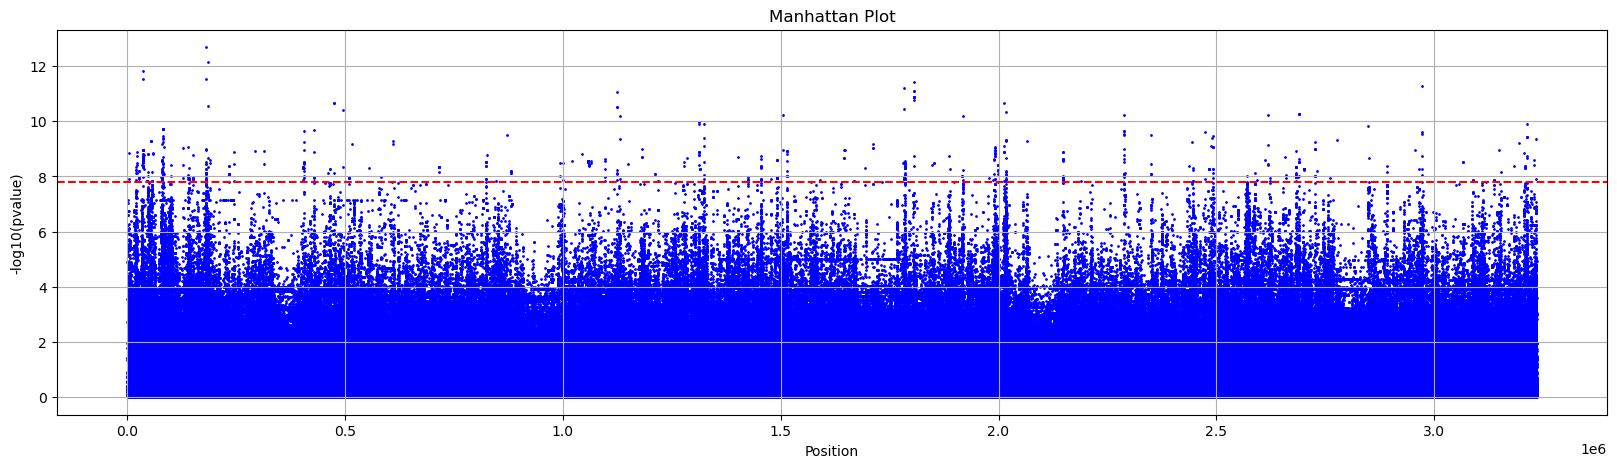

In [29]:
# Transform p-value into -log10(p-value) to enhance visibility on the plot
df['-log10(pvalue)'] = -np.log10(df['pvalue'])

# Creating the Manhattan plot
plt.figure(figsize=(20, 5))  # Set the figure size as needed
plt.scatter(df['pos'], df['-log10(pvalue)'], color='blue', marker='o', s =1)  # Use different colors if multiple chromosomes

# Aesthetics
plt.xlabel('Position')
plt.ylabel('-log10(pvalue)')
plt.title('Manhattan Plot')
plt.grid(True)

# Threshold line (optional, adjust the threshold as needed)
threshold = -np.log10(threshold_value)  # Example threshold for p-value of 0.05
plt.axhline(y=threshold, color='red', linestyle='dashed')

# Show the plot
plt.show()
